In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-u72psuti
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-u72psuti
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp37-none-any.whl size=8312 sha256=ea88806578e223943e95734a0e191d9fbde17db36f00c4a6ccc32e4e113cdeda
  Stored in directory: /tmp/pip-ephem-wheel-cache-tswcxz89/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
     |████████████████████████████████| 51kB 2.7MB/s 


In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample
import io
from keras_vggface.vggface import VGGFace


dataset = pd.read_csv('/content/drive/My Drive/fer2013.csv')


In [4]:
def convert_pixels_to_img(pixels):
    pixels = pixels/255
    test_image = pixels.reshape(48,48)

    return test_image

def split_pixels(string):
    splitted = np.array(string.split(),'int')
    return splitted 

def change_to_categorical(sample):
    return keras.utils.to_categorical(sample,num_classes=7)

def grayscale_to_rgb(grayscale_image): 
    rgb_image = np.stack((grayscale_image,)*3, axis=-1)
    return rgb_image 

dataset['pixels'] = dataset['pixels'].apply(split_pixels)
dataset['label'] = dataset['emotion'].apply(change_to_categorical)
dataset['length'] = dataset['pixels'].apply(len)

dataset = dataset[dataset.length == 2304]
dataset['image'] = dataset['pixels'].apply(convert_pixels_to_img)
dataset['image'] = dataset['image'].apply(grayscale_to_rgb)

grouped_dataset = dataset.groupby(dataset.Usage)
training_dataset = grouped_dataset.get_group("Training")
dev_dataset = grouped_dataset.get_group("PublicTest")
test_dataset = grouped_dataset.get_group("PrivateTest")


# def balancingDataset(data, x):
#     new_df = data.loc[data['emotion']==x]
#     data_to_add = 8000 - len(new_df)
#     random_sampling = resample(new_df,random_state=42,replace=True,n_samples=data_to_add)
#     return pd.concat([new_df,random_sampling])

# df_0=balancingDataset(training_dataset,0)
# df_2=balancingDataset(training_dataset,2)
# df_3=balancingDataset(training_dataset,3)
# df_4=balancingDataset(training_dataset,4)
# df_5=balancingDataset(training_dataset,5)
# df_6=balancingDataset(training_dataset,6)


# training_dataset_aug=pd.concat([df_0,df_2,df_3,df_4,df_5,df_6])

# Pandas dataframe
x_train = training_dataset['image']
y_train = training_dataset['label']
x_test =  dev_dataset['image']
y_test = dev_dataset['label']

#Pandas dataframe to numpy
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

#numpy array reshape to fit into model
x_train = np.stack(x_train,axis=0)
y_train = np.stack(y_train,axis=0)
x_test = np.stack(x_test,axis=0)
y_test = np.stack(y_test,axis=0)



In [13]:
emotion_labels = {0:'Angry', 1:'Disgust',2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
def int_to_emotion(x):
    return emotion_labels[x]
def get_distribution(data):
    emotion_count = data['emotion'].value_counts()
    
    #emotion_count.index = emotion_count.index.map(int_to_emotion)
    print("Distribution count of emotions in the dataset:")
    print(emotion_count)
    print("")
    dict_count = emotion_count.to_dict()
    class_weights = {}
    total_samples = sum(list(dict_count.values()))
    for c in dict_count.keys():
        weight = (1/dict_count[c]) * (total_samples/2)
        class_weights[c] = weight 
    print(class_weights)
    return class_weights

class_weights = get_distribution(training_dataset)  

Distribution count of emotions in the dataset:
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

{3: 1.9895356895356895, 6: 2.8911379657603224, 4: 2.9719461697722567, 2: 3.503661215523554, 0: 3.5931163954943677, 5: 4.526805424156418, 1: 32.92316513761468}


In [11]:

datagen = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
generator=datagen.flow(x_train,y_train,batch_size=64)

In [14]:
vgg_model = VGGFace(include_top=False,input_shape=(48,48,3))

x = vgg_model.output
x = layers.Flatten()(x)
x = layers.Dense(units=4096,activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(units=1024, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(units=7, activation="softmax")(x)

new_model = keras.Model(inputs=vgg_model.input, outputs=x)

#from keras.models import load_model

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, mode='auto')
checkpointer = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Emotion Recognition/Model/vgg_face_class_weights.h5', monitor='val_loss', verbose=1, save_best_only=True)


new_model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
new_model.summary()
# new_model = load_model('/content/drive/My Drive/Colab Notebooks/Emotion Recognition/Model/vggface_sgd.h5')

history = new_model.fit(generator,batch_size=64,epochs=200,verbose=1,
                        validation_data=(x_test, y_test),callbacks=[lr_reducer,early_stopper,checkpointer],class_weight=class_weights)


58916864/58909280 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 48, 48, 64)        1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 48, 48, 64)        36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 24, 24, 128)       147584    
______________________________________________________________

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


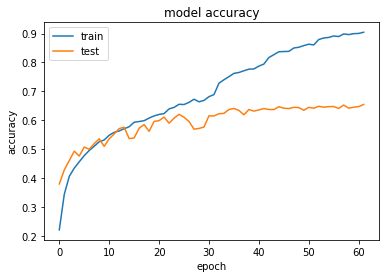

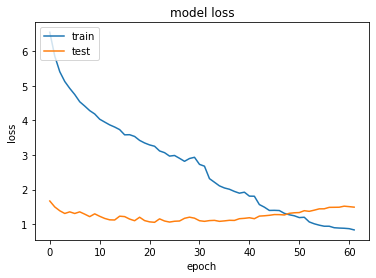

In [15]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()